# Модель склонности: определение клиентов, склонных к открытию депозита в банке.

## 1. Постановка задачи

В данном проекте нам предстоит решить задачу для банковского сектора: определить клиентов, наиболее склонных к открытию депозита в банке для проведения взаимодействия именно с этими клиентами. Это может быть необходимо по причине ограниченного бюджета маркетинговой компании и/или сохранения лояльности клиентов, чтобы избежать взаимодействия с клиентами, не склонными к пробретению данного продукта.

Так как нам предоставлены данные о последней маркетинговой кампании, которую проводил банк в целях привлечения клиентов для открытия депозита, мы можем построить response модель.

**Бизнес-задача**: определить характеристики, по которым можно выявить клиентов, более склонных к открытию депозита в банке, и за счёт этого повысить результативность маркетинговой кампании.

**Техническая задача**: построить модель машинного обучпения для решения задачи классификации, которая на основе предложенных характеристик клиента будет предсказывать, воспользуется он предложением об открытии депозита или нет.

**Основные этапы проекта:**
1. Первичная обработка данных (очистка от пропусков и выбросов)
2. Разведывательный анализ данных (EDA)
3. Отбор и преобразование признаков
4. Построение нескольких моделей для задачи классификации и выбор наилучшей из них
5. Подбор гиперпараметров для улучшения качества модели

## 2. Знакомство с данными, обработка пропусков и выбросов

Заранее импортируем модули, которые нам понадобятся для решения задачи:

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import cross_val_score
import optuna


Прочитаем наш файл с исходными данными:

In [21]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


Файл содержит следующие характеристики.

**Данные о клиентах банка:**

- age (возраст);
- job (сфера занятости);
- marital (семейное положение);
- education (уровень образования);
- default (имеется ли просроченный кредит);
- housing (имеется ли кредит на жильё);
- loan (имеется ли кредит на личные нужды);
- balance (баланс).

**Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:**

- contact (тип контакта с клиентом);
- month (месяц, в котором был последний контакт);
- day (день, в который был последний контакт);
- duration (продолжительность контакта в секундах).

**Прочие признаки:**

- campaign (количество контактов с этим клиентом в течение текущей кампании);
- pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
- previous (количество контактов до текущей кампании)
- poutcome (результат прошлой маркетинговой кампании).

И целевая переменная **deposit**, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


Исследуем данные на предмет пропусков.

In [23]:
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

Пропуски содержатся только в признаке 'balance'. 

Посмотрим внимательной на признаки типа object, возможно в них также содержатся пропуски, заполненные иным образом.

In [24]:
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

Действительно, в признаке 'job' присутствует значение 'unknown', которое также свидетельствует об отсутствии данных.

Признак 'balance' имеет тип object. Преобразуем признак balance таким образом, чтобы он корректно считывался, как вещественное число.

In [25]:
df['balance'] = df['balance'].apply(
    lambda x: float(x[:-3].replace(',','.').replace(' ','')) if x is not np.nan else x
    )
df['balance'].mean()

1529.1290293615875

Обработаем пропуски в признаки balance, заменив их на медианные значения по данному признаку

In [26]:
df = df.fillna({'balance': df['balance'].median()})
df['balance'].describe()

count    11162.000000
mean      1526.936033
std       3224.829691
min      -6847.000000
25%        123.000000
50%        550.000000
75%       1699.000000
max      81204.000000
Name: balance, dtype: float64

Обработаем пропуски в категориальных признаках: job и education, заменив их на модальные значения

In [27]:
popular_job = df['job'].mode()[0]
popular_education = df['education'].mode()[0]

df['job'] = df['job'].apply(lambda x: popular_job if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x: popular_education if x == 'unknown' else x)

Удалим выбросы для признака 'balance' по методу Тьюки

In [28]:
x = df['balance']
quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
iqr = quartile_3 - quartile_1
lower_bound = quartile_1 - (iqr * 1.5)
upper_bound = quartile_3 + (iqr * 1.5)
outliers = df[(x < lower_bound) | (x > upper_bound)]
df = df[(x >= lower_bound) & (x <= upper_bound)]

print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {df.shape[0]}')
print(f'Верхняя граница: {upper_bound}')
print(f'Нижняя граница: {lower_bound}')

Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105
Верхняя граница: 4063.0
Нижняя граница: -2241.0


## 3. Разведывательный анализ (EDA)

Изучим соотношение классов в данных на предмет несбалансированности

In [29]:
fig = px.histogram(
    df['deposit'],
    title='Соотношение числа открывших депозит и не открывших'
    )
fig.show()

Количество клиентов, не открывших депозит, больше, но классы примерно сбалансированы.

Рассчитаем описательные статистики для количественных переменных

In [30]:
cat_columns = df.dtypes[df.dtypes == 'object'].index
num_columns = df.dtypes[df.dtypes != 'object'].index

df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


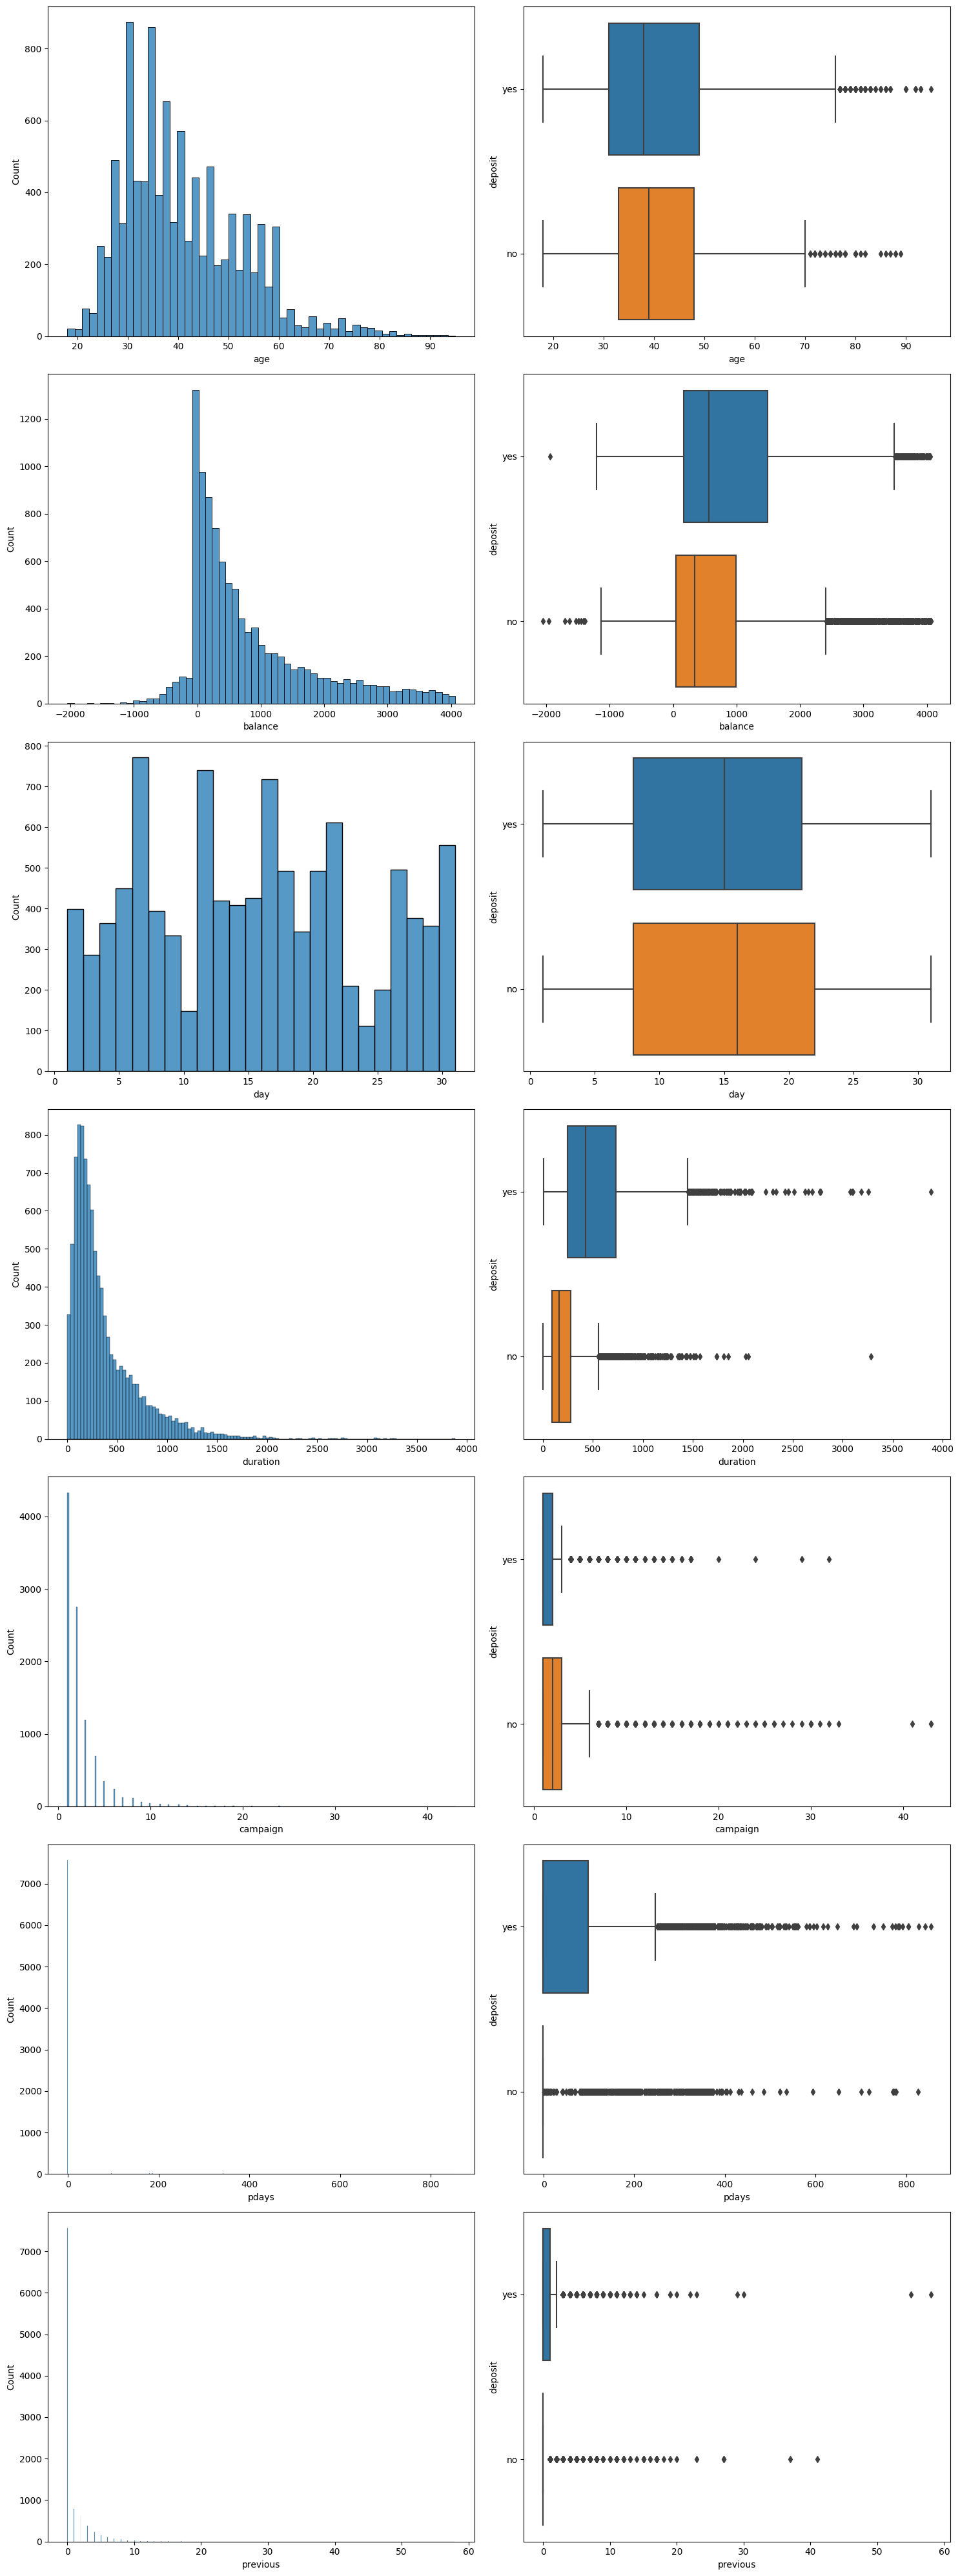

In [31]:
n = len(num_columns) #число количественных признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 40)) #фигура+n*2 координатных плоскостей
#Создаём цикл для всех признаков из списка числовых признаков
for i, feature in enumerate(num_columns):
    hist = sns.histplot(data=df, x=feature, ax=axes[i][0])
    box = sns.boxplot(data=df, x=feature, y='deposit', ax=axes[i][1])
plt.tight_layout() #выравнивание графиков

На основании построенных графиков, можно сделать предположение, что среди количественных признаков наибольшее влияние оказывают признаки 'balance', 'duration', 'campaign'. Признак 'pdays', 'previous' имеет очень большой разброс, при этом большинство значений равно 0 для обоих категорий целевого признака. 
Признак 'day' логичнее рассматривать, как категоральный, так как он имеет ограниченное число дискретных значений.

In [32]:
df['day'] = df['day'].astype('object')

Рассчитаем описательные статистики для категориальных переменных.

In [33]:
df.describe(include='object')

,job,marital,education,default,housing,loan,contact,day,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,31,12,4,2
top,management,married,secondary,no,no,no,cellular,18,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,493,2617,7570,5424


Для удобства переобозначим целевой признак: 1 - открыл депозит, 0 - нет.

In [34]:
df['deposit'] = df['deposit'].apply(lambda x: 1 if x == 'yes' else 0)
cat_columns = df.dtypes[df.dtypes == 'object'].index

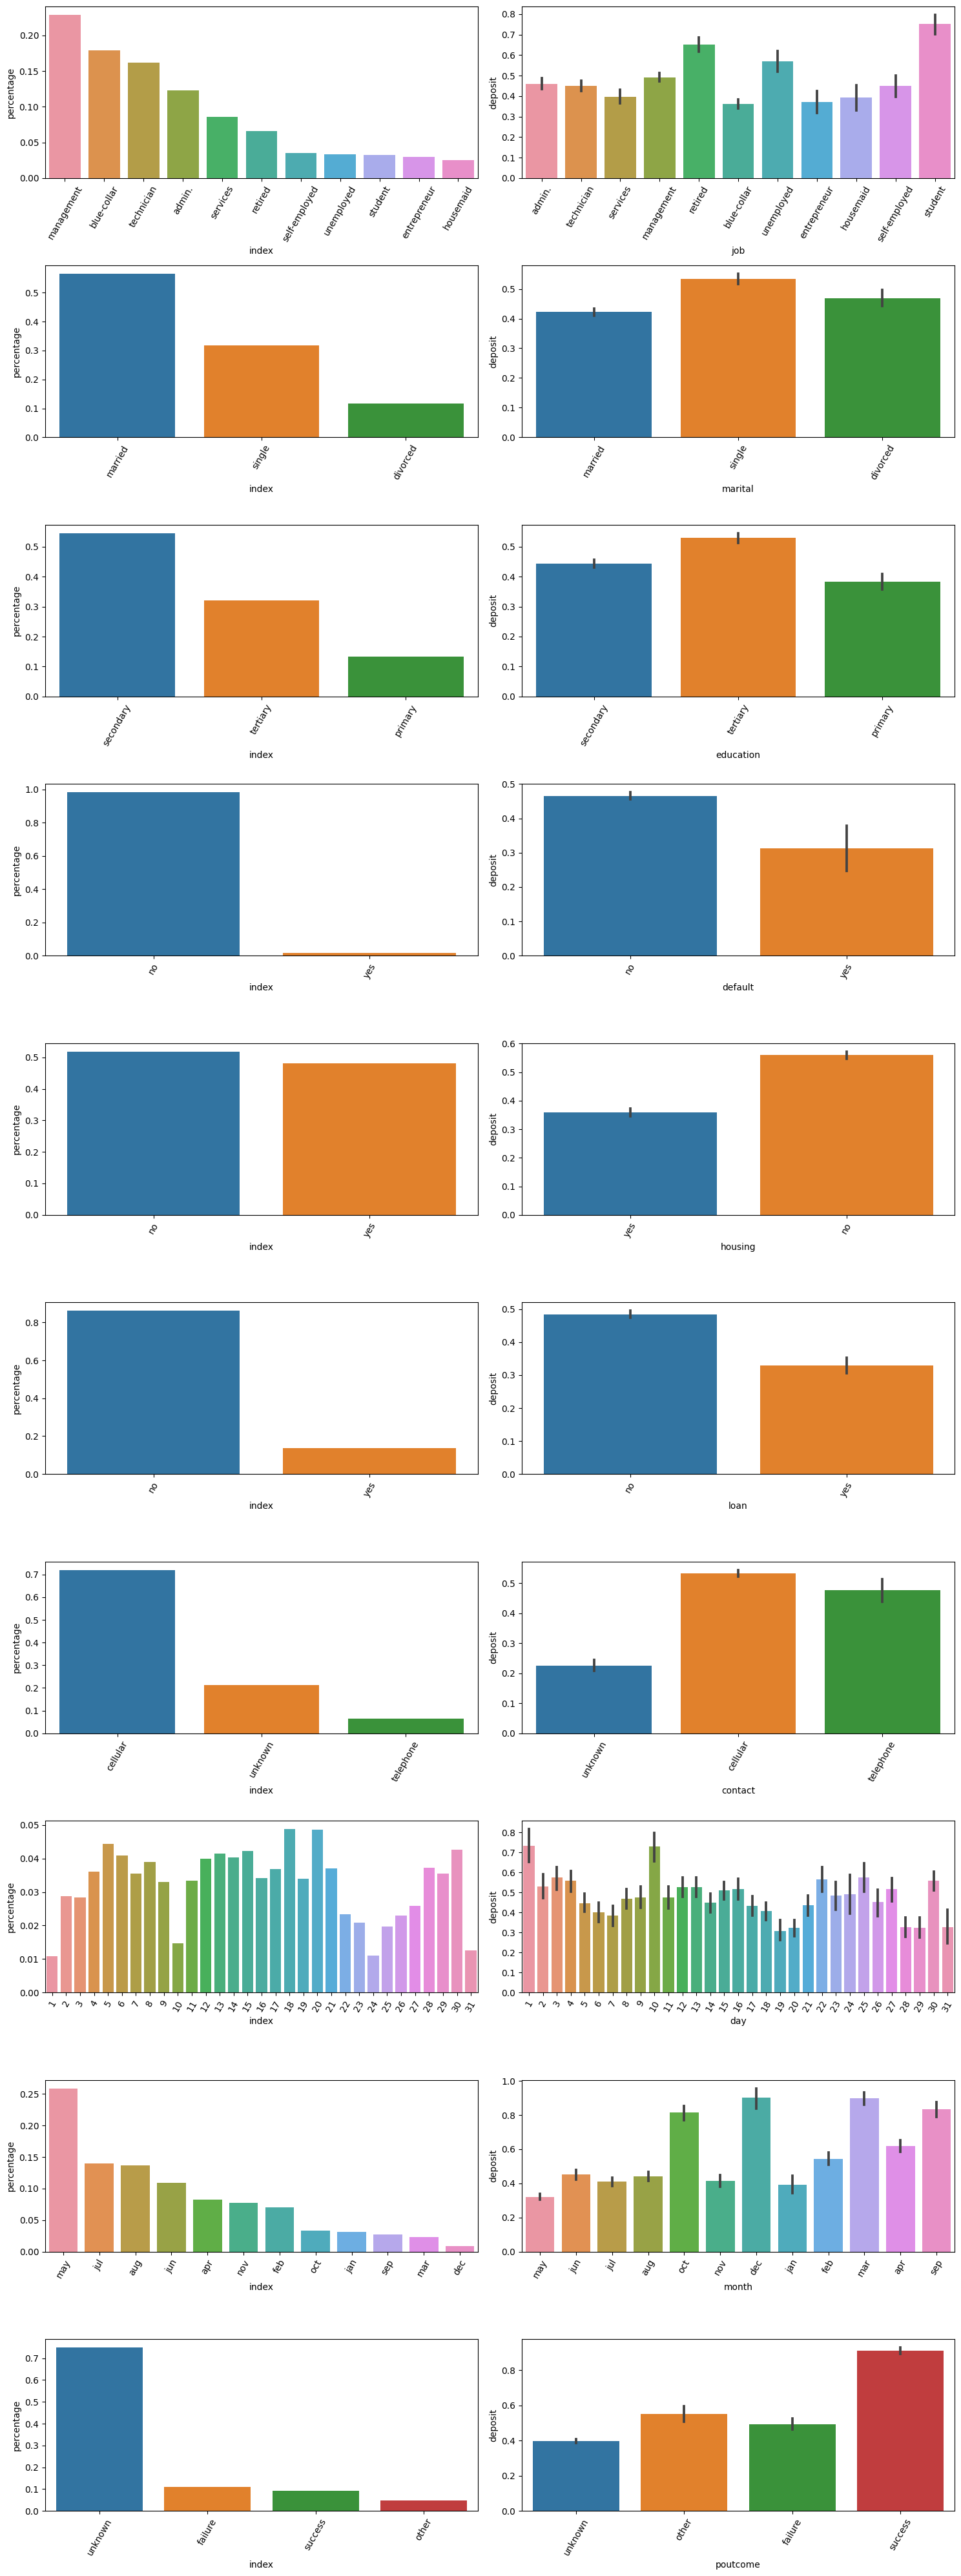

In [35]:
n = len(cat_columns) #число категориальных признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 40)) #фигура+n*2 координатных плоскостей
#Создаём цикл для всех признаков из списка категориальных признаков
for i, feature in enumerate(cat_columns):
    #Строим количественную столбчатую диаграмму для долевого соотношения каждой из категорий в данных
    count_data = (df[feature].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  .reset_index())
    count_barplot = sns.barplot(data=count_data, x='index', y='percentage', ax=axes[i][0])
    count_barplot.xaxis.set_tick_params(rotation=60)
    #Строим столбчатую диаграмму доли людей открывшых депозит в зависимости от категории
    mean_barplot = sns.barplot(data=df, x=feature, y='deposit', ax=axes[i][1])
    #barplot(data=df, x=feature, y='deposit', ax=axes[i][1])
    mean_barplot.xaxis.set_tick_params(rotation=60)
plt.tight_layout() #выравнивание графиков

На графиках наблюдается зависимость целевого признака от признаков:
- 'job' - наибольшая доля, открывших кредит среди категорий student, retire и unemployement.
- 'marital' - открывают депозит чаще одинокие, затем разведенные, и реже в браке.
- 'education' -  открывают депозит чаще с более высоким уровнем образования
- 'default', loan', 'housing' - наличие кредита уменьшает вероятность открытия депозита
- 'poutcome' - успешная предыдущая маркетинговая компания повышает шансы открытия депзита

Создадим возрастные группы и определим, в каких группах более склонны открывать депозит, чем отказываться от предложения


<AxesSubplot: xlabel='age_group', ylabel='count'>

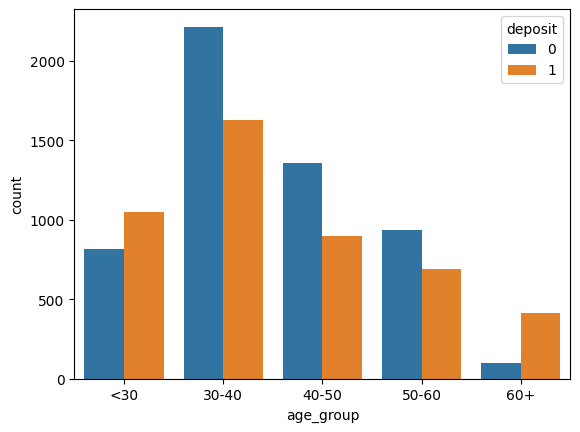

In [36]:
df['age_group'] = pd.cut(df.age, [0,30,40,50,60,9999], labels = ['<30','30-40','40-50','50-60','60+'])
sns.countplot(x="age_group", hue="deposit", data=df)

Больше всего склонны к открытию депозита возрастные группы <30 и 60+, при этом среди клиентов большую часть составляет категория 30-40

Построим сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны в положительном классе (т.е. среди тех, кто открыл депозит)

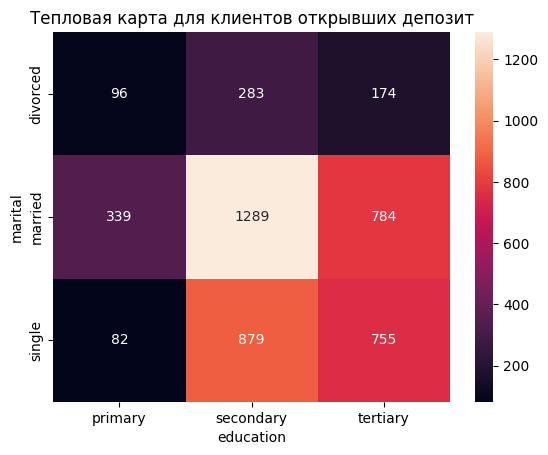

In [37]:
deposit_yes = pd.crosstab(df[df['deposit'] == 1]['marital'], df[df['deposit'] == 1]['education'])
heatmap_yes = sns.heatmap(deposit_yes, annot=True, fmt='.0f')
heatmap_yes.set_title('Тепловая карта для клиентов открывших депозит');

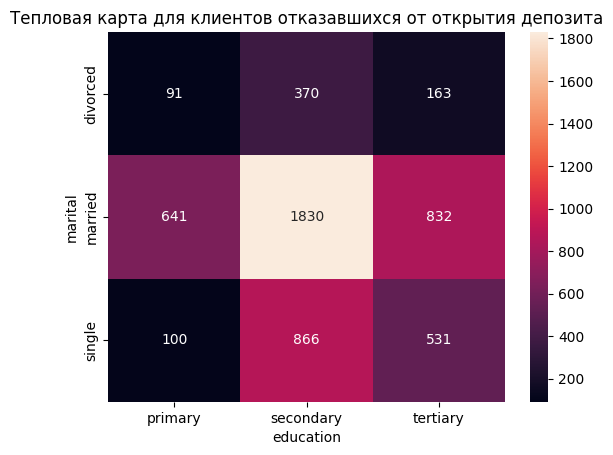

In [38]:
deposit_no = pd.crosstab(df[df['deposit'] == 0]['marital'], df[df['deposit'] == 0]['education'])
heatmap_no = sns.heatmap(deposit_no, annot=True, fmt='.0f')
heatmap_no.set_title('Тепловая карта для клиентов отказавшихся от открытия депозита');

Среди обеих групп самая многочисленная категория - это клиенты в браке с уровнем образования secondary. Но среди отказавшихся от открытия доля этой группы выше. Среди открывших депозит также высокие доли одиноких клиентов с уровнем образования secondary и tertiary.

## 4. Преобразование данных

Преобразуем бинарные переменные в представление из нулей и единиц

In [40]:
df['default'] = df['default'].apply(lambda x: 1 if x == 'yes' else 0)
df['housing'] = df['housing'].apply(lambda x: 1 if x == 'yes' else 0)
df['loan'] = df['loan'].apply(lambda x: 1 if x == 'yes' else 0)

Закодируем с помощью OneHotEncoder остальные категориальные признаки


In [41]:
# создайте дамми-переменные
df= pd.get_dummies(df, columns=['job','marital','contact','month','poutcome', 'education', 'age_group'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 52 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  10105 non-null  int64  
 1   default              10105 non-null  int64  
 2   balance              10105 non-null  float64
 3   housing              10105 non-null  int64  
 4   loan                 10105 non-null  int64  
 5   day                  10105 non-null  object 
 6   duration             10105 non-null  int64  
 7   campaign             10105 non-null  int64  
 8   pdays                10105 non-null  int64  
 9   previous             10105 non-null  int64  
 10  deposit              10105 non-null  int64  
 11  job_admin.           10105 non-null  uint8  
 12  job_blue-collar      10105 non-null  uint8  
 13  job_entrepreneur     10105 non-null  uint8  
 14  job_housemaid        10105 non-null  uint8  
 15  job_management       10105 non-null 

Построим корреляционную матрицу и оценим данные на предмет наличия мультиколлинеарности

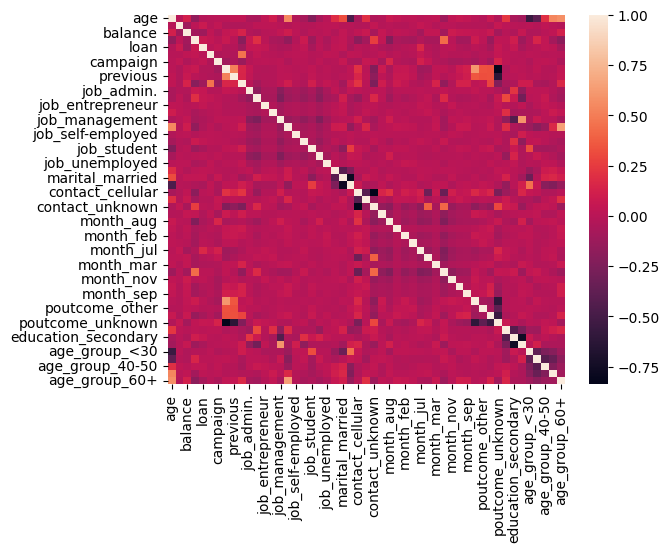

In [42]:
corr = df.corr()
sns.heatmap(corr);

In [43]:
fig = px.bar(corr['deposit'], y=abs(corr['deposit'].values), 
             title='Корреляция признаков с целевой переменной')
fig.update_xaxes(categoryorder='total descending')
fig.show()

Разделим выборку на обучающую и тестовую

In [44]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [45]:
X_test.shape

(3335, 51)

С помощью SelectKBest отберем 15 наиболее подходящих признаков

In [46]:
select_feature = SelectKBest(score_func = f_classif, k=15)
select_feature.fit(X_train, y_train)
X_selected_train = select_feature.transform(X_train)
X_selected_test = select_feature.transform(X_test)
select_feature.get_feature_names_out()

array(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'contact_cellular', 'contact_unknown', 'month_mar', 'month_may',
       'month_oct', 'month_sep', 'poutcome_success', 'poutcome_unknown',
       'age_group_60+'], dtype=object)

Нормализуем данные с помощью minmaxsxaler

In [48]:
m_scaler = preprocessing.MinMaxScaler()
m_scaler.fit(X_selected_train)
X_scaled_train = m_scaler.transform(X_selected_train)
X_scaled_test = m_scaler.transform(X_selected_test)

# 5. Решение задачи классификации: логистическая регрессия и решающие деревья

Обучим логистическую регрессию и рассчитаем метрики качества

In [52]:
log_reg = linear_model.LogisticRegression(solver='sag', 
                                          random_state=42, 
                                          max_iter=1000)
log_reg.fit(X_scaled_train, y_train)
y_pred_train = log_reg.predict(X_scaled_train)
y_pred_test = log_reg.predict(X_scaled_test)
print('Accuracy на тренировочной выборке: ', metrics.accuracy_score(y_train, y_pred_train))
print('Accuracy на тестовой выборке: ', metrics.accuracy_score(y_test, y_pred_test))
print('F1 на тренировочной выборке: ', metrics.f1_score(y_train, y_pred_train))
print('F1 на тестовой выборке: ', metrics.f1_score(y_test, y_pred_test))

Accuracy на тренировочной выборке:  0.8214180206794682
Accuracy на тестовой выборке:  0.8053973013493253
F1 на тренировочной выборке:  0.7970454926976666
F1 на тестовой выборке:  0.7778158165011984


Обучим решающие деревья.

In [53]:
dt = tree.DecisionTreeClassifier(criterion='entropy',
                                 max_depth=7,
                                 random_state=42
                                 )
dt.fit(X_scaled_train, y_train)
y_pred_train = dt.predict(X_scaled_train)
y_pred_test = dt.predict(X_scaled_test)
print('Accuracy на тренировочной выборке: ', metrics.accuracy_score(y_train, y_pred_train))
print('Accuracy на тестовой выборке: ', metrics.accuracy_score(y_test, y_pred_test))
print('F1 на тренировочной выборке: ', metrics.f1_score(y_train, y_pred_train))
print('F1 на тестовой выборке: ', metrics.f1_score(y_test, y_pred_test))

Accuracy на тренировочной выборке:  0.8242245199409158
Accuracy на тестовой выборке:  0.8032983508245877
F1 на тренировочной выборке:  0.8054919908466819
F1 на тестовой выборке:  0.7822045152722444


Подберем оптимальные параметры с помощью gridsearch

In [51]:
param_grid = {
    'min_samples_split': [2, 5, 7, 10],
    'max_depth': [3, 5, 7]
}

grid_search_dt = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs = -1
)

grid_search_dt.fit(X_scaled_train, y_train)
y_train_pred = grid_search_dt.predict(X_scaled_train)
y_test_pred = grid_search_dt.predict(X_scaled_test)
print('F1 на тренировочной выборке: ', metrics.f1_score(y_train, y_train_pred))
print('F1 на тестовой выборке: ', metrics.f1_score(y_test, y_test_pred))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_dt.best_params_))

F1 на тренировочной выборке:  0.8086021505376344
F1 на тестовой выборке:  0.778
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 5}


# 6. Решение задачи классификации: ансамбли моделей и построение прогноза

Обучим модель случайного леса

In [54]:
rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)
rf.fit(X_scaled_train, y_train)
y_train_pred = rf.predict(X_scaled_train)
y_test_pred = rf.predict(X_scaled_test)
print('F1 на тренировочной выборке: ', metrics.f1_score(y_train, y_train_pred))
print('F1 на тестовой выборке: ', metrics.f1_score(y_test, y_test_pred))
print(metrics.classification_report(y_test, y_test_pred))

F1 на тренировочной выборке:  0.8428167243005344
F1 на тестовой выборке:  0.8164174355711104
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



Построим модель градиентного бустинга.

In [55]:

gb = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)
gb.fit(X_scaled_train, y_train)
y_train_pred = gb.predict(X_scaled_train)
y_test_pred = gb.predict(X_scaled_test)
print('F1 на тренировочной выборке: ', metrics.f1_score(y_train, y_train_pred))
print('F1 на тестовой выборке: ', metrics.f1_score(y_test, y_test_pred))
print(metrics.classification_report(y_test, y_test_pred))

F1 на тренировочной выборке:  0.8716248223590715
F1 на тестовой выборке:  0.8126801152737753
              precision    recall  f1-score   support

           0       0.84      0.83      0.84      1790
           1       0.80      0.82      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



Объединим построенные алгоритмы с помощью стекинга 

In [56]:
# Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('lr', log_reg),
    ('dt',  dt),
    ('gb', gb)
]

# Создаем объект класса стекинг
stc = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)
# Обучаем модель
stc.fit(X_scaled_train, y_train)
y_train_pred = stc.predict(X_scaled_train)
y_test_pred = stc.predict(X_scaled_test)
print('F1 на тренировочной выборке: ', metrics.f1_score(y_train, y_train_pred))
print('F1 на тестовой выборке: ', metrics.f1_score(y_test, y_test_pred))
print(metrics.classification_report(y_test, y_test_pred))

F1 на тренировочной выборке:  0.8540765657536441
F1 на тестовой выборке:  0.8058441558441559
              precision    recall  f1-score   support

           0       0.83      0.84      0.83      1790
           1       0.81      0.80      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



Оценим наиболее значимые признаки в модели градиентного бустинга

In [57]:
features_importances = pd.Series(
    gb.feature_importances_, 
    index=select_feature.get_feature_names_out()
    )
fig = px.bar(features_importances,  
             x=features_importances.values,
             title='Impotances Features'
             )
fig.update_yaxes(categoryorder='total ascending')
fig.show()

Выполним оптимизацию гиперпараметров с помощью Optuna для лучшей модели. В нашем случае это модель случайного леса.

In [58]:

def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # применим  cross validation
  score = cross_val_score(model, X_scaled_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()

  return score

# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study_rf = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study_rf.optimize(optuna_rf, n_trials=20)
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study_rf.best_params))
print("f1_score на обучающем наборе: {}".format(study_rf.best_value))

# рассчитаем метрику для тестовой выборки
model = ensemble.RandomForestClassifier(**study_rf.best_params,random_state=42)
model.fit(X_scaled_train, y_train)
y_train_pred = model.predict(X_scaled_train)
y_test_pred = model.predict(X_scaled_test)
print('f1_score на тренировочном наборе: ', metrics.f1_score(y_train, y_train_pred))
print('f1_score на тестовом наборе: ', metrics.f1_score(y_test, y_test_pred))

[I 2023-12-11 12:15:10,022] A new study created in memory with name: RandomForestClassifier


[I 2023-12-11 12:15:23,570] Trial 0 finished with value: 0.8187386235933138 and parameters: {'n_estimators': 166, 'max_depth': 14, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8187386235933138.
[I 2023-12-11 12:15:29,433] Trial 1 finished with value: 0.8173826670711962 and parameters: {'n_estimators': 193, 'max_depth': 21, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8187386235933138.
[I 2023-12-11 12:15:35,190] Trial 2 finished with value: 0.8199815484761219 and parameters: {'n_estimators': 130, 'max_depth': 17, 'min_samples_leaf': 7}. Best is trial 2 with value: 0.8199815484761219.
[I 2023-12-11 12:15:44,901] Trial 3 finished with value: 0.8195658519825711 and parameters: {'n_estimators': 168, 'max_depth': 21, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.8199815484761219.
[I 2023-12-11 12:15:54,292] Trial 4 finished with value: 0.8204691020848353 and parameters: {'n_estimators': 186, 'max_depth': 17, 'min_samples_leaf': 4}. Best is trial 4 with value: 0.820

Наилучшие значения гиперпараметров {'n_estimators': 199, 'max_depth': 24, 'min_samples_leaf': 3}
f1_score на обучающем наборе: 0.8234351294329528
f1_score на тренировочном наборе:  0.8906691800188501
f1_score на тестовом наборе:  0.8125594671741199


7. Выводы:

В рамках работы над проектом мы построили несколько моеделей для решения задачи классификации. Лучшее качество показала модель случайного леса:
F1 на тестовой выборке:  0.8164174355711104